**Business Problem**:
To develop a model for predicting **sgtf **(S gene target failure) from the samples having collected on those particular days  is to analyze the dataset based

**Out-of-Scope Considerations**

For this analysis, certain elements are considered out-of-scope:

1. **Advanced Feature Engineering:**

Additional domain-specific features could be engineered to improve performance, such as trends over time or external factors influencing sgtf. However, this would require domain expertise and is not included in this model.

2. **Alternative Modeling Techniques:**

While logistic regression is effective for binary classification, other algorithms (e.g., decision trees, random forests, or boosting techniques) might yield better results, particularly if the data has non-linear relationships. Testing multiple models was out-of-scope here.

3. **Hyperparameter Tuning Beyond Regularization:**

This analysis focused only on tuning the regularization parameter C. Other parameters (such as different solvers or optimization strategies) could further improve performance, but they were not explored.

4. **Class Imbalance Techniques Beyond Class Weighting:**

The model used class balancing with class_weight='balanced' to handle class imbalance. Other techniques like SMOTE or undersampling were not considered but might be explored for fine-tuning.

5. **External Validation:**

The model was only validated on the current dataset. For a more robust assessment, it would be beneficial to validate the model on an independent, external dataset if available.

6. **Real-Time and Dynamic Data Adjustments:**

Since specimen_date was transformed to reflect days from the present, the model would need updates or adjustments to remain accurate in real-time scenarios. Incorporating automated data updates or retraining mechanisms was out-of-scope.


**Overview**: This code implements a logistic regression model to classify data based on features provided in the dataset. The model employs data preprocessing steps, scaling, and hyperparameter tuning using Grid Search to optimize the regularization parameter C. The performance of the model is evaluated using metrics such as accuracy, confusion matrix, and classification report.

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import files
uploaded = files.upload()

Saving sgtf_regionepicurve_2021-12-30.csv to sgtf_regionepicurve_2021-12-30.csv


In [3]:
data = pd.read_csv(next(iter(uploaded)))

In [4]:
# Display basic info about the dataset to verify loading
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UKHSA_region   943 non-null    object 
 1   specimen_date  943 non-null    object 
 2   n              943 non-null    int64  
 3   percent        943 non-null    float64
 4   sgtf           943 non-null    object 
 5   total          943 non-null    int64  
 6   conf_low       943 non-null    float64
 7   conf_high      943 non-null    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 59.1+ KB
None
    UKHSA_region specimen_date    n  percent                         sgtf  \
0  East Midlands    01/11/2021  874   100.00  Cases with confirmed S-gene   
1  East Midlands    02/11/2021  724    99.86  Cases with confirmed S-gene   
2  East Midlands    02/11/2021    1     0.14    Cases with confirmed SGTF   
3  East Midlands    03/11/2021  757   100.00  Cases with confirmed S-gene   
4  

In [5]:
target = 'sgtf'
features = [col for col in data.columns if col not in [target,]]
print(features)
print(data[target].value_counts())

['UKHSA_region', 'specimen_date', 'n', 'percent', 'total', 'conf_low', 'conf_high']
sgtf
Cases with confirmed S-gene    522
Cases with confirmed SGTF      421
Name: count, dtype: int64


In [6]:
# Encode categorical features (e.g., 'UKHSA_region')
label_encoder = LabelEncoder()
data['UKHSA_region'] = label_encoder.fit_transform(data['UKHSA_region'])
#convert datatype of datetime into datetime
data['specimen_date'] = pd.to_datetime(data['specimen_date'], format='%d/%m/%Y')
# Use Lamda fuunction to convert the datetime  to realtime values
data['specimen_date'] = data['specimen_date'].apply(lambda x: (datetime.now() - x).days)
print(data.info())
print(data.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UKHSA_region   943 non-null    int64  
 1   specimen_date  943 non-null    int64  
 2   n              943 non-null    int64  
 3   percent        943 non-null    float64
 4   sgtf           943 non-null    object 
 5   total          943 non-null    int64  
 6   conf_low       943 non-null    float64
 7   conf_high      943 non-null    float64
dtypes: float64(3), int64(4), object(1)
memory usage: 59.1+ KB
None
   UKHSA_region  specimen_date    n  percent                         sgtf  \
0             0           1103  874   100.00  Cases with confirmed S-gene   
1             0           1102  724    99.86  Cases with confirmed S-gene   
2             0           1102    1     0.14    Cases with confirmed SGTF   
3             0           1101  757   100.00  Cases with confirmed S-gene   
4  

**Label Encoding:** Converts the categorical feature UKHSA_region into numerical values.

**Date Conversion:** The specimen_date column is converted to datetime format and transformed to represent the number of days since each date to the present.

**Lambda function:** lambda function calculates the number of days between the specimen date and the current date (datetime.now()). This transformation makes the date feature suitable for models that work with numerical data

In [7]:
X = data[features]
y = data[target]
print(X)
print(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

     UKHSA_region  specimen_date     n  percent  total   conf_low   conf_high
0               0           1103   874   100.00    874  99.454454  100.000000
1               0           1102   724    99.86    725  99.109120   99.992800
2               0           1102     1     0.14    725   0.007200    0.890880
3               0           1101   757   100.00    757  99.370567  100.000000
4               0           1100   598   100.00    598  99.204289  100.000000
..            ...            ...   ...      ...    ...        ...         ...
938             8           1048  6049    91.71   6596  91.009196   92.355890
939             8           1047   664     6.53  10175   6.057379    7.027367
940             8           1047  9511    93.47  10175  92.972633   93.942621
941             8           1046   310     4.42   7008   3.959804    4.937905
942             8           1046  6698    95.58   7008  95.062095   96.040196

[943 rows x 7 columns]
0      Cases with confirmed S-gene
1    

This setup prepares the dataset for further modeling, with features and target separated and the data split into training and testing sets. These steps ensure that the model can be trained on one subset and evaluated on another, enabling performance assessment on unseen data.

**Purpose: **Split the data into training and testing sets to evaluate model performance.

**Training Set (X_train, y_train):** Used to train the model.

**Testing Set (X_test, y_test):** Used to evaluate the model's accuracy and performance on unseen data.








In [8]:
'''
X_train_num = X_train[numerical_features]
X_test_num = X_test[numerical_features]
print(X_train_num)
print(X_test_num)'''

'\nX_train_num = X_train[numerical_features]\nX_test_num = X_test[numerical_features]\nprint(X_train_num)\nprint(X_test_num)'

In [9]:

scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:

print(X_train)
print(X_test)
print(y_train)
print(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

[[2.50000000e-01 7.19298246e-01 1.08083560e-01 ... 8.51254480e-02
  9.95523500e-01 9.99535229e-01]
 [0.00000000e+00 2.10526316e-01 1.65109641e-01 ... 2.23775388e-01
  6.23540297e-01 6.52299944e-01]
 [2.50000000e-01 8.77192982e-02 6.75943947e-01 ... 6.47431302e-01
  9.36721770e-01 9.44401922e-01]
 ...
 [1.00000000e+00 7.36842105e-01 0.00000000e+00 ... 1.57168459e-01
  5.88115620e-06 7.30221689e-04]
 [5.00000000e-01 8.59649123e-01 2.30245232e-01 ... 1.97610514e-01
  9.98549364e-01 9.99781574e-01]
 [0.00000000e+00 3.50877193e-02 1.12819515e-01 ... 9.86260454e-02
  9.05330779e-01 9.29399484e-01]]
[[0.00000000e+00 8.77192982e-02 3.72648242e-01 ... 3.75866189e-01
  8.71709467e-01 8.86433007e-01]
 [2.50000000e-01 5.26315789e-01 7.11690671e-02 ... 5.14934289e-02
  9.85254723e-01 9.96021119e-01]
 [8.75000000e-01 2.10526316e-01 1.40716232e-01 ... 2.00119474e-01
  5.88107545e-01 6.19043564e-01]
 ...
 [1.25000000e-01 9.82456140e-01 6.48760867e-05 ... 5.55555556e-02
  2.82955483e-04 5.32255050e-03]

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define the model with class balancing
model = LogisticRegression(class_weight='balanced')


 Initializes a logistic regression model with **class_weight='balanced'**, automatically adjusting the weights to handle any class imbalance in the target variable.

In [12]:

# Set up K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)  # 5-fold cross-validation

# Perform cross-validation and get accuracy scores
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Define the parameter grid for GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

Cross-Validation Scores: [0.78807947 0.75496689 0.76821192 0.74834437 0.73333333]
Mean CV Accuracy: 0.7585871964679912


Purpose: Uses Grid Search to try multiple values of 𝐶(the regularization parameter), aiming to find the value that provides the best performance. Here:

**Parameter Grid: **
C values are tested across six settings (from 0.001 to 100).

**5-Fold Cross-Validation: **Each 𝐶value is evaluated five times with different training and validation splits to ensure a robust estimate of model performance.

In [13]:

# Regularization strengths to try

# Perform GridSearchCV with cross-validation

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Get the best parameter and best score from the grid search
best_C = grid_search.best_params_['C']
print("Best Regularization Parameter (C):", best_C)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train a new model using the best found regularization parameter
best_model = LogisticRegression(class_weight='balanced', C=best_C)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nTest Accuracy Score:", accuracy_score(y_test, y_pred))




Best Regularization Parameter (C): 100
Best Cross-Validation Accuracy: 0.8646975717439294
Confusion Matrix:
 [[89 15]
 [ 5 80]]

Classification Report:
                              precision    recall  f1-score   support

Cases with confirmed S-gene       0.95      0.86      0.90       104
  Cases with confirmed SGTF       0.84      0.94      0.89        85

                   accuracy                           0.89       189
                  macro avg       0.89      0.90      0.89       189
               weighted avg       0.90      0.89      0.89       189


Test Accuracy Score: 0.8941798941798942


Interpretation: The Grid Search process identified
C=100 as the optimal regularization parameter for this logistic regression model. A higher C value reduces the regularization strength, allowing the model to better capture patterns in the data without over-penalizing larger coefficients.

**Best Cross-Validation Accuracy:**
**Interpretation:**  It indicates that, on average, the model correctly classified approximately 86.47% of the samples in each fold. Cross-validation accuracy provides a more reliable measure of model performance than a single test set, as it reduces variability from different data splits.

**Confusion Matrix:**

[[89 15]
 [ 5 80]]
True Positives (Cases with confirmed S-gene correctly identified): 89
False Positives (Cases with confirmed SGTF misclassified as S-gene): 15
False Negatives (Cases with confirmed S-gene misclassified as SGTF): 5
True Negatives (Cases with confirmed SGTF correctly identified): 80

Interpretation: The confusion matrix shows that the model performs well on both classes but has a slightly higher misclassification rate for “Cases with confirmed S-gene” than “Cases with confirmed SGTF.” The relatively low number of false negatives (5) for the SGTF class indicates that the model is particularly good at identifying this class.

Classification Report:

**For “Cases with confirmed S-gene”:**

Precision: 0.95 - Indicates that 95% of the positive predictions for this class are correct.

Recall: 0.86 - The model correctly identified 86% of all true S-gene cases.

F1-Score: 0.90 - Represents a balanced measure of precision and recall.

**For “Cases with confirmed SGTF”:**

Precision: 0.84 - Indicates that 84% of the positive predictions for this class are correct.

Recall: 0.94 - The model identified 94% of true SGTF cases correctly.

F1-Score: 0.89 - A balanced score showing high accuracy for the SGTF class.

Overall Accuracy: 0.89 or 89% on the test set.
Interpretation: The model performs well across both classes, with a slight emphasis on identifying SGTF cases correctly (high recall). This is often beneficial in scenarios where capturing all instances of a particular class is more critical.

**Test Accuracy Score:**

Value: 0.8941 or 89.41%

**Interpretation:** The model achieved an accuracy of 89.41% on the test set, which is consistent with its cross-validation accuracy. This indicates good generalization and low overfitting.

Confusion Matrix:
 [[99  5]
 [ 3 82]]

Classification Report:
                              precision    recall  f1-score   support

Cases with confirmed S-gene       0.97      0.95      0.96       104
  Cases with confirmed SGTF       0.94      0.96      0.95        85

                   accuracy                           0.96       189
                  macro avg       0.96      0.96      0.96       189
               weighted avg       0.96      0.96      0.96       189


Test Accuracy Score: 0.9576719576719577


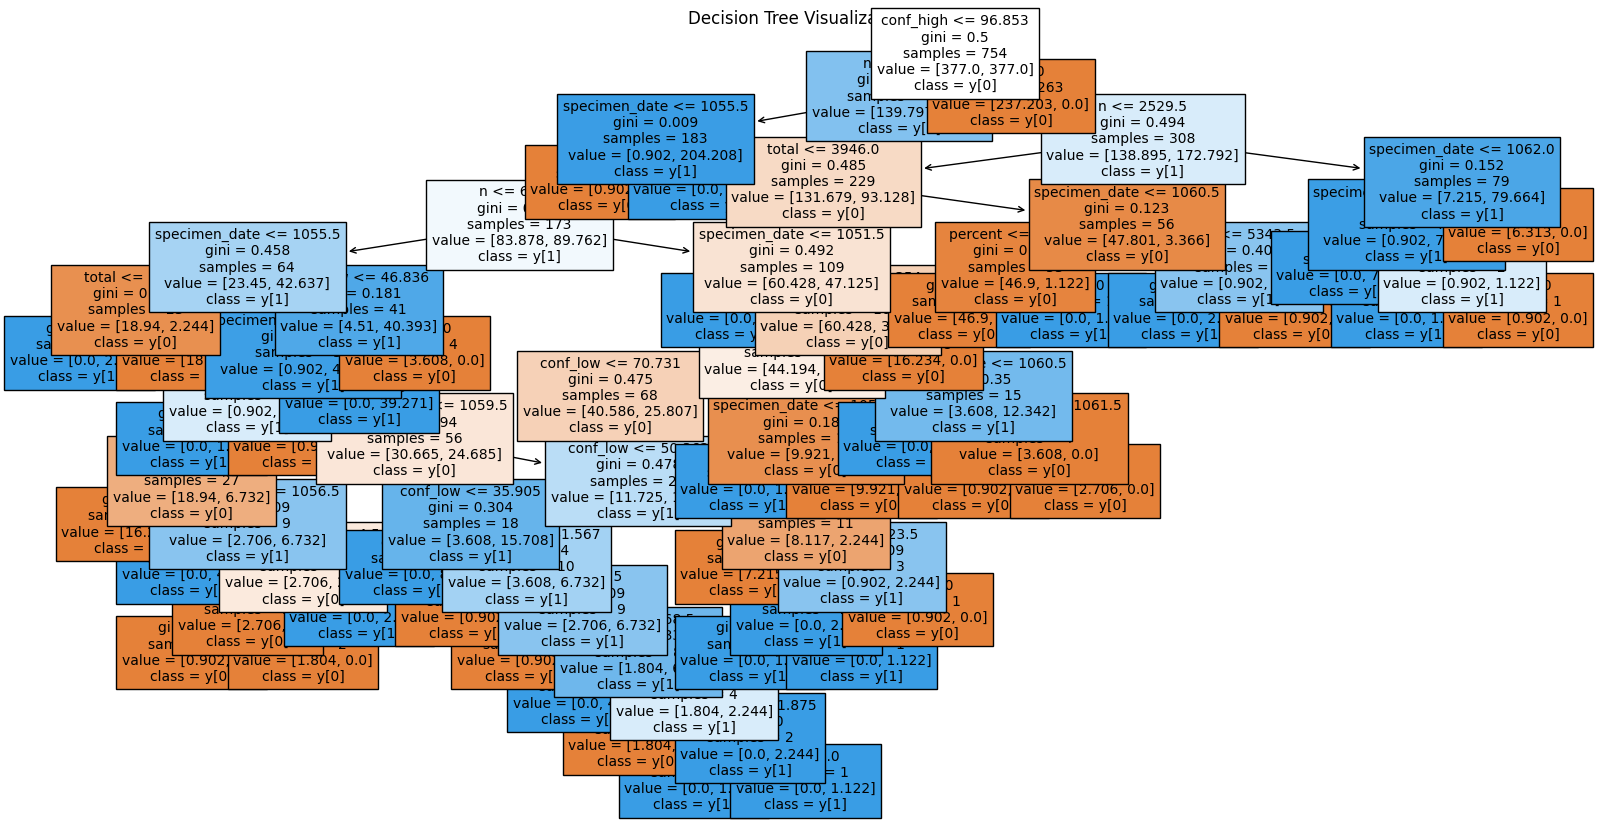

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
def train_and_evaluate_decision_tree(X, y, test_size=0.2, random_state=42):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    dt_model = DecisionTreeClassifier(class_weight='balanced')
    dt_model.fit(x_train, y_train)
    y_pred = dt_model.predict(x_test)

    # Moved the following lines inside the function
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nTest Accuracy Score:", accuracy_score(y_test, y_pred))
# Plotting the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=True, fontsize=10) # Now dt_model is accessible
    plt.title("Decision Tree Visualization")
    plt.show()
    return dt_model
dt_model = train_and_evaluate_decision_tree(X, y)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],   # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# Initialize the RandomForest with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predicting the test set results
y_pred = best_rf.predict(X_test)

# Printing the evaluation metrics
print("Best Parameters:", grid_search.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test Accuracy Score:", accuracy_score(y_test, y_pred))



Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
283 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Confusion Matrix:
 [[101   3]
 [  3  82]]
Classification Report:
                              precision    recall  f1-score   support

Cases with confirmed S-gene       0.97      0.97      0.97       104
  Cases with confirmed SGTF       0.96      0.96      0.96        85

                   accuracy                           0.97       189
                  macro avg       0.97      0.97      0.97       189
               weighted avg       0.97      0.97      0.97       189

Test Accuracy Score: 0.9682539682539683


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scipy.stats import randint as sp_randint

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up the parameter distributions
param_dist = {
    'n_estimators': sp_randint(100, 300),  # Randomly sample values in the range 100-300
    'max_features': ['auto', 'sqrt'],      # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],       # Maximum number of levels in tree
    'min_samples_split': sp_randint(2, 11),# Randomly sample values in the range 2-10
    'min_samples_leaf': sp_randint(1, 5)   # Randomly sample values in the range 1-4
}

# Initialize the RandomForest with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Setup the random search and fit it
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=10, cv=3, verbose=2, random_state=42, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_

# Predicting the test set results
y_pred = best_rf.predict(X_test)

# Printing the evaluation metrics
print("Best Parameters:", random_search.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test Accuracy Score:", accuracy_score(y_test, y_pred))




Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 157}
Confusion Matrix:
 [[100   4]
 [  2  83]]
Classification Report:
                              precision    recall  f1-score   support

Cases with confirmed S-gene       0.98      0.96      0.97       104
  Cases with confirmed SGTF       0.95      0.98      0.97        85

                   accuracy                           0.97       189
                  macro avg       0.97      0.97      0.97       189
               weighted avg       0.97      0.97      0.97       189

Test Accuracy Score: 0.9682539682539683


Decision Tree Performance:
Confusion Matrix:
 [[99  5]
 [ 3 82]]
Classification Report:
                              precision    recall  f1-score   support

Cases with confirmed S-gene       0.97      0.95      0.96       104
  Cases with confirmed SGTF       0.94      0.96      0.95        85

                   accuracy                           0.96       189
                  macro avg       0.96      0.96      0.96       189
               weighted avg       0.96      0.96      0.96       189

Accuracy Score: 0.9576719576719577

Random Forest Performance:
Confusion Matrix:
 [[101   3]
 [  3  82]]
Classification Report:
                              precision    recall  f1-score   support

Cases with confirmed S-gene       0.97      0.97      0.97       104
  Cases with confirmed SGTF       0.96      0.96      0.96        85

                   accuracy                           0.97       189
                  macro avg       0.97      0.97      0.97       189
               wei

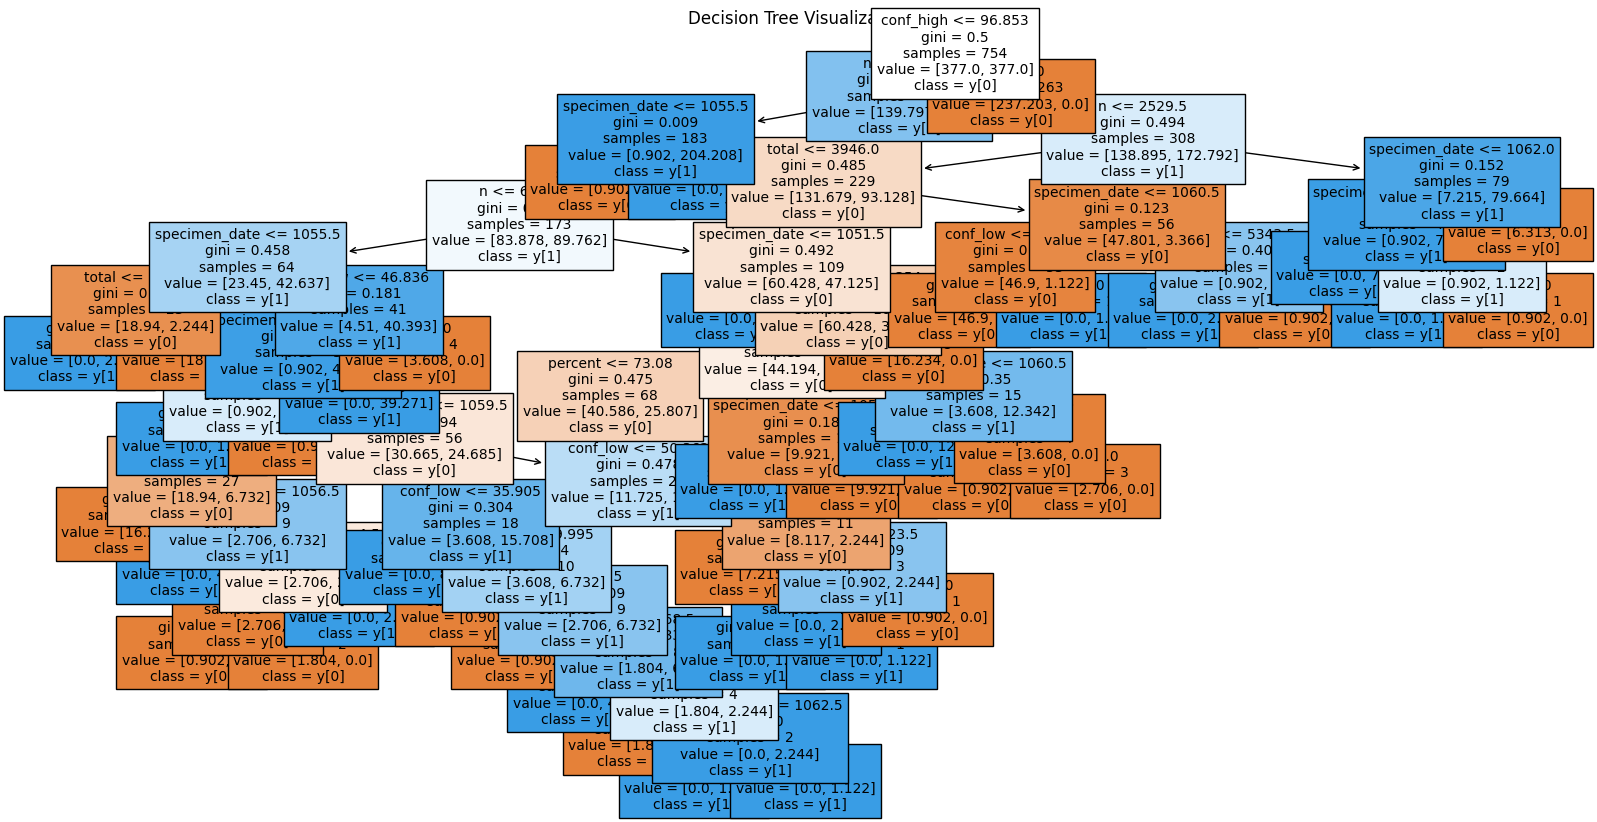

In [17]:
def compare_models(X, y, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Decision Tree Model
    dt_model = DecisionTreeClassifier(class_weight='balanced')
    dt_model.fit(x_train, y_train)
    dt_pred = dt_model.predict(x_test)

    # Random Forest Model
    rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
    rf_model.fit(x_train, y_train)
    rf_pred = rf_model.predict(x_test)

    # Evaluate models
    print("Decision Tree Performance:")
    print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
    print("Classification Report:\n", classification_report(y_test, dt_pred))
    print("Accuracy Score:", accuracy_score(y_test, dt_pred))

    print("\nRandom Forest Performance:")
    print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
    print("Classification Report:\n", classification_report(y_test, rf_pred))
    print("Accuracy Score:", accuracy_score(y_test, rf_pred))

    # Plotting the decision tree for visualization
    plt.figure(figsize=(20,10))
    plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=True, fontsize=10)
    plt.title("Decision Tree Visualization")
    plt.show()

# Assuming X and y are defined elsewhere in your code
compare_models(X, y)

In [18]:
#Using naive Bayes algorithm to fid the probability of finding Cases with confirmed S-gene
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Convert the targert column into numerical
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

y_train = y_train.astype(int)
y_test = y_test.astype(int)
print(y_train)
print(y_test)

model = GaussianNB()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#probability of getting the samples tested as Cases with confirmed S-gene
class_index = list(label_encoder.classes_).index('Cases with confirmed S-gene')
y_pred_prob = model.predict_proba(X_test)[:, class_index]

# Calculate and print the average probability of 'Cases with confirmed S-gene'
average_probability = y_pred_prob.mean()
print("Average probability of 'Cases with confirmed S-gene':", average_probability)



# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nTest Accuracy Score:", accuracy_score(y_test, y_pred))

[0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1
 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 0
 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1
 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0
 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0
 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1
 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1
 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1
 0 1 0 0 0 0 0 1 1 1 1 0 

In [20]:
#Generate a Support Vector Machine algorithm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)

# Fit the model
svm_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = svm_model.predict(X_test)



#accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8994708994708994
Confusion Matrix:
 [[96  8]
 [11 74]]


In [ ]:
#Violin Plots for the above dataset
import seaborn as sns
import matplotlib.pyplot as plt

